In [1]:
!nvidia-smi 

Sun Feb 27 05:26:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/aflw2k3d/1.0.0.incompleteICT3MU/aflw2k3d-train.tfrecord


  0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset aflw2k3d downloaded and prepared to /root/tensorflow_datasets/aflw2k3d/1.0.0. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


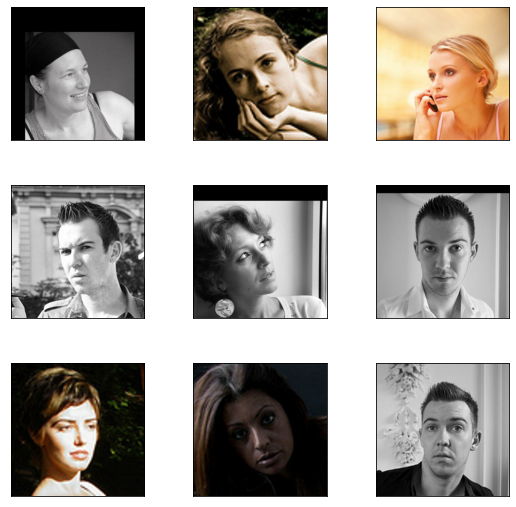

In [3]:
ds_train, ds_info = tfds.load('aflw2k3d', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
batch_size = 128
image_shape = (64, 64, 3)

In [5]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    return image

In [6]:
ds_train = ds_train.map(preprocess).shuffle(ds_info.splits['train'].num_examples).batch(batch_size, drop_remainder=True).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

16


In [7]:
class WGAN_GP():
    
    def __init__(self, input_shape):
        
        self.z_dim = 128
        self.input_shape = input_shape
        
        self.loss_critic = {}
        self.loss_gp = {}
        self.loss_generator = []
        
        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False
        
        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)
        
        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):
        
        w_loss = -tf.reduce_mean(y_true*y_pred)
        
        return w_loss
    
    def build_generator(self):
        
        DIM = 128
        model = tf.keras.Sequential(name='Generator')
        
        model.add(layers.Input(shape=[self.z_dim]))
        
        model.add(layers.Dense(4*4*2*DIM))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,2*DIM)))
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(4*DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(DIM, 5, padding='same'))
        model.add(layers.LayerNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        
        return model
    
    def build_critic(self):
        
        DIM = 128
        model = tf.keras.Sequential(name='critics')
        
        model.add(layers.Input(shape=self.input_shape))
        
        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(8*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        
        return model
    
    def gradient_loss(self, grad):
        
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1, len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss-1))
        loss = self.penalty_const * loss
        return loss
    
    def train_critic(self, real_images, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)
        
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)
            
            # gradient penalty
            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
            
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradinets
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))
            
        return loss_fake, loss_real, gradient_penalty
    
    def train(self, data_generator, batch_size, steps, interval=100):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
                
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            #self.loss_gp[i] = gradient_penalty
            #self.loss_critic[i] = critic_loss.numpy()
            #self.loss_generator[i] = g_loss
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic_fake {:.4f} critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)
                
                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                #self.plot_losses()
                
    def plot_images(self, images):
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*3.5, grid_row*3.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1] == 1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off')
        plt.show()
        
    def plot_losses(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title('Critic loss')
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title('Generator loss')
        ax3.plot(list(self.loss_gp.values()), label='Gradient penalty', alpha=0.7)
        ax3.set_title('Gradient penalty')
        plt.xlabel('Steps')
        plt.show()

In [8]:
wgan = WGAN_GP(image_shape)

Step 0: g_loss 1.9946 critic_loss -4.2958 critic_fake -2.4131 critic_real -1.8826 penalty 3.0543


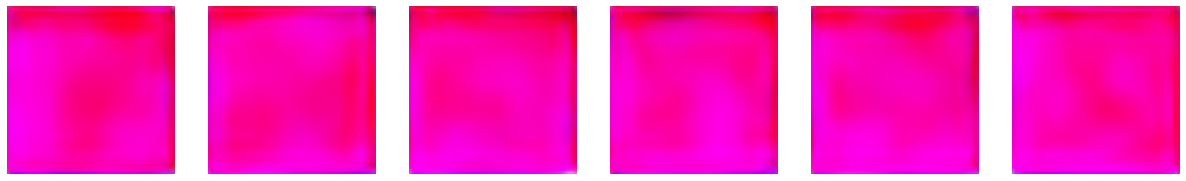

Step 16: g_loss 4.4310 critic_loss -8.6129 critic_fake -4.8320 critic_real -3.7808 penalty 1.5602


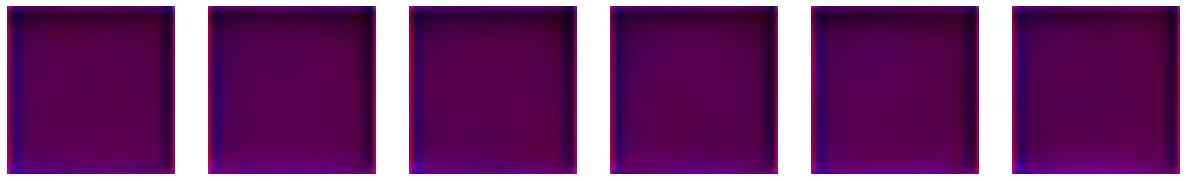

Step 32: g_loss -0.7187 critic_loss -7.4387 critic_fake 1.0827 critic_real -8.5215 penalty 0.7848


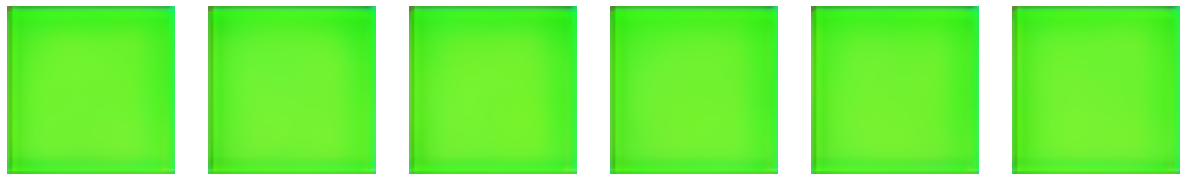

Step 48: g_loss 3.2772 critic_loss -7.3203 critic_fake -2.3177 critic_real -5.0026 penalty 0.4433


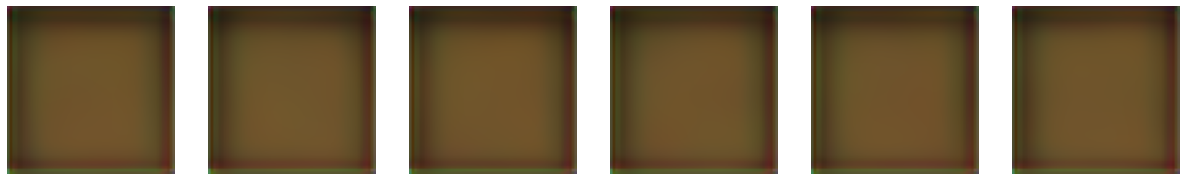

Step 64: g_loss 3.2721 critic_loss -7.8046 critic_fake -3.0790 critic_real -4.7256 penalty 0.7620


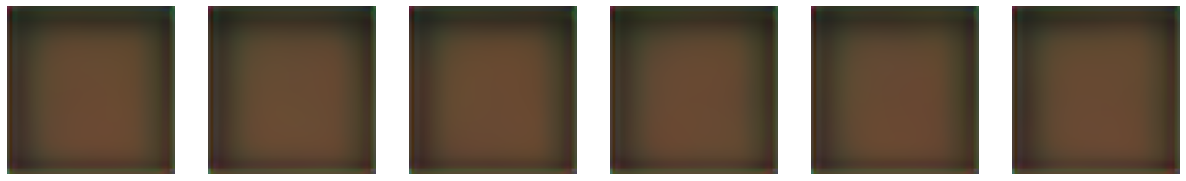

Step 80: g_loss 1.1030 critic_loss -5.3670 critic_fake -1.1614 critic_real -4.2056 penalty 0.0384


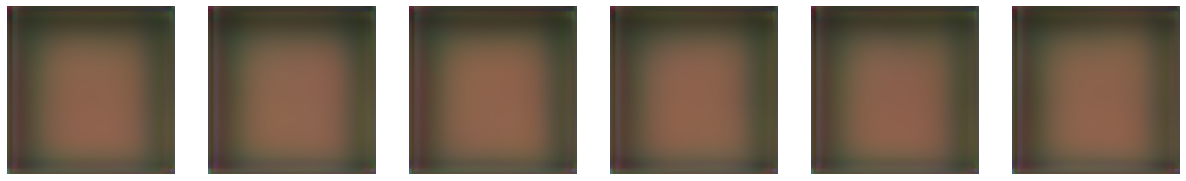

Step 96: g_loss 0.5623 critic_loss -5.9949 critic_fake -0.4683 critic_real -5.5266 penalty 0.3855


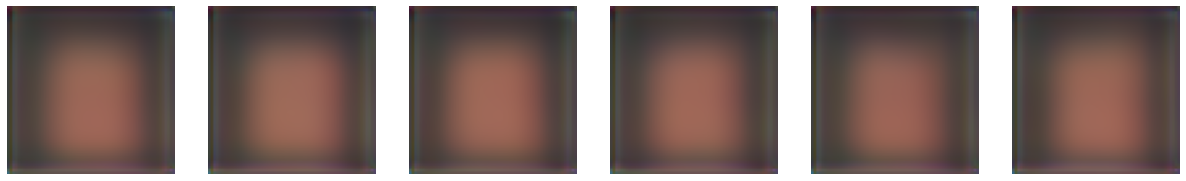

Step 112: g_loss 0.5161 critic_loss -7.5179 critic_fake -0.2008 critic_real -7.3171 penalty 2.3427


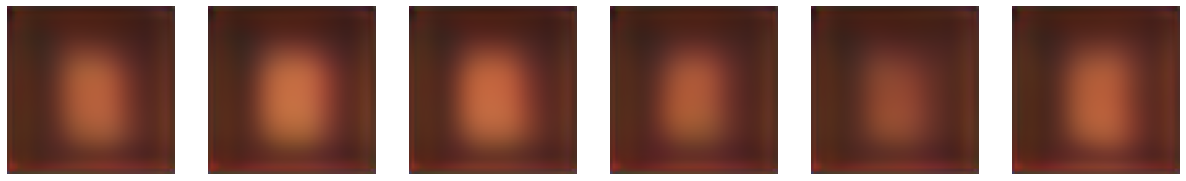

Step 128: g_loss 0.7133 critic_loss -5.5333 critic_fake -0.6931 critic_real -4.8402 penalty 0.2515


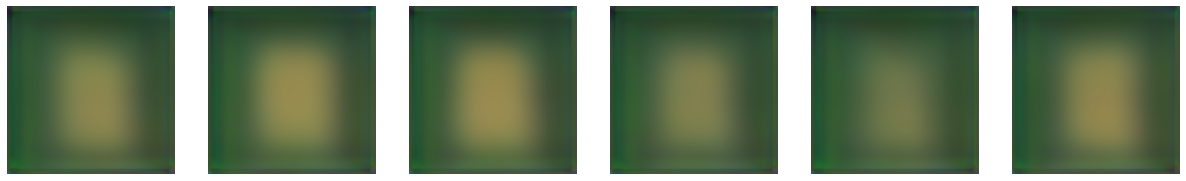

Step 144: g_loss 0.9557 critic_loss -5.1096 critic_fake -0.8579 critic_real -4.2517 penalty 0.2968


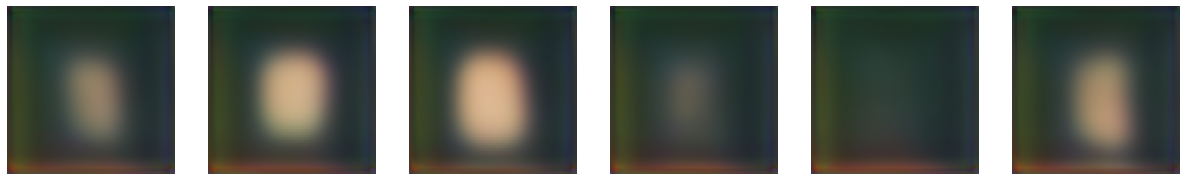

Step 160: g_loss -0.5095 critic_loss -3.8976 critic_fake 0.5549 critic_real -4.4525 penalty 0.0773


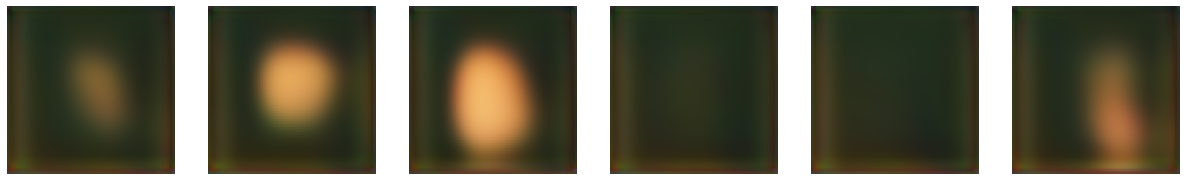

Step 176: g_loss 0.4143 critic_loss -4.6910 critic_fake -0.4468 critic_real -4.2442 penalty 0.3546


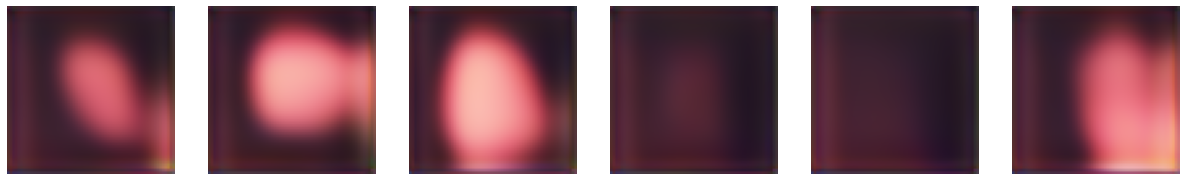

Step 192: g_loss 0.8908 critic_loss -3.7824 critic_fake -0.6263 critic_real -3.1561 penalty 0.1069


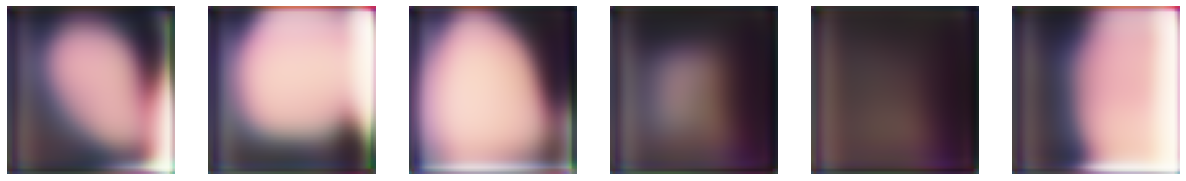

Step 208: g_loss -1.3982 critic_loss -3.3361 critic_fake 1.5394 critic_real -4.8755 penalty 0.2093


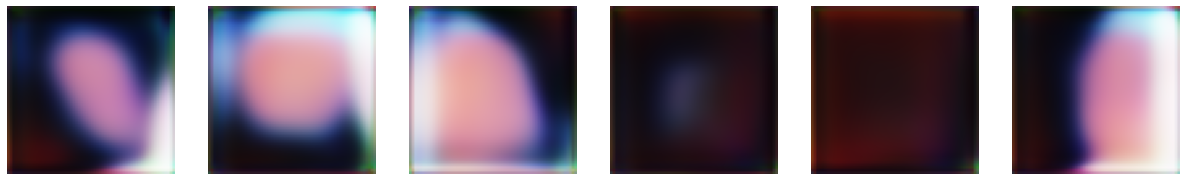

Step 224: g_loss -1.1283 critic_loss -2.9756 critic_fake 0.3436 critic_real -3.3192 penalty 0.0229


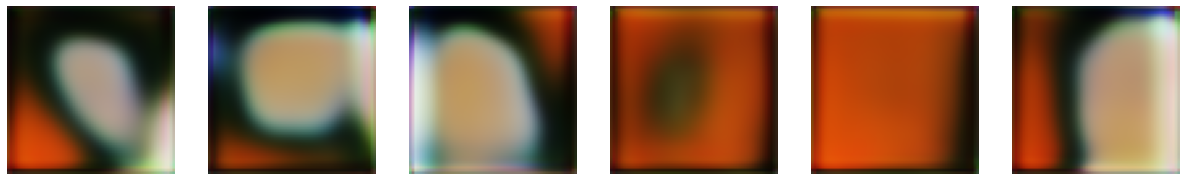

Step 240: g_loss 1.8663 critic_loss -3.3931 critic_fake -1.5602 critic_real -1.8328 penalty 0.1692


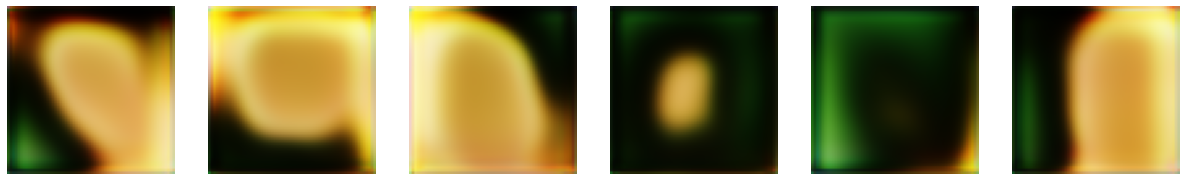

Step 256: g_loss 0.7191 critic_loss -2.6204 critic_fake -0.4675 critic_real -2.1529 penalty 0.1999


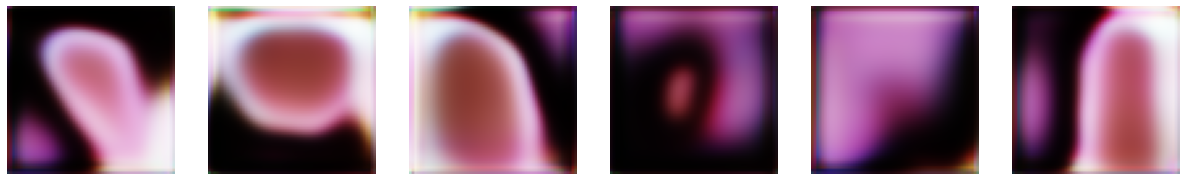

Step 272: g_loss 0.0556 critic_loss -2.5653 critic_fake -0.3851 critic_real -2.1803 penalty 0.1304


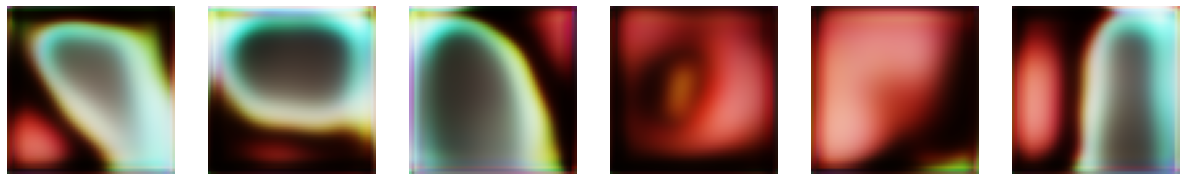

Step 288: g_loss -0.4326 critic_loss -2.8819 critic_fake 0.0623 critic_real -2.9442 penalty 0.1914


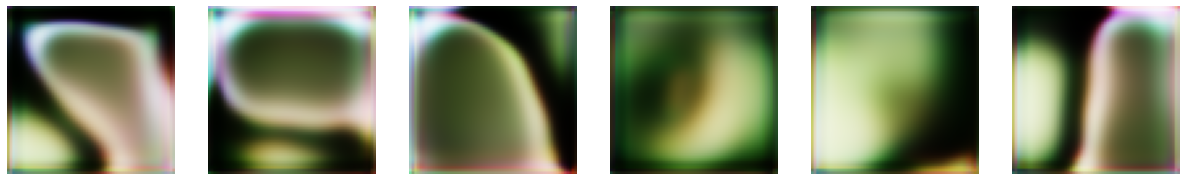

Step 304: g_loss 0.0067 critic_loss -2.6275 critic_fake -0.1430 critic_real -2.4845 penalty 0.0028


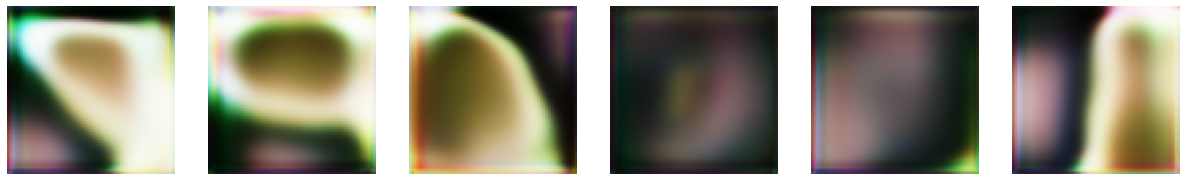

Step 320: g_loss 2.3019 critic_loss -2.8412 critic_fake -2.5847 critic_real -0.2565 penalty 0.0832


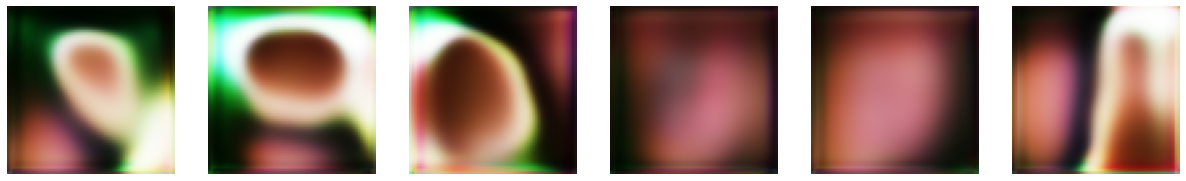

Step 336: g_loss 2.5262 critic_loss -2.9516 critic_fake -2.1721 critic_real -0.7795 penalty 0.2931


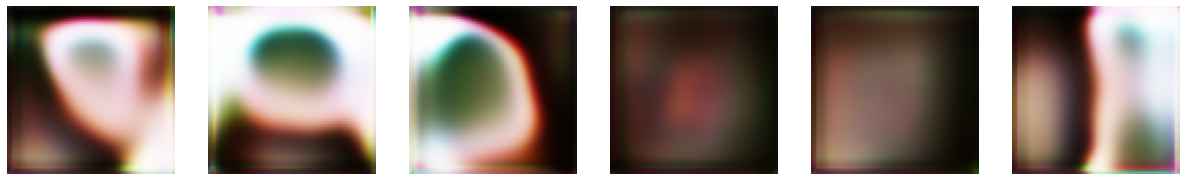

Step 352: g_loss 0.5600 critic_loss -3.0513 critic_fake -0.1919 critic_real -2.8594 penalty 0.1583


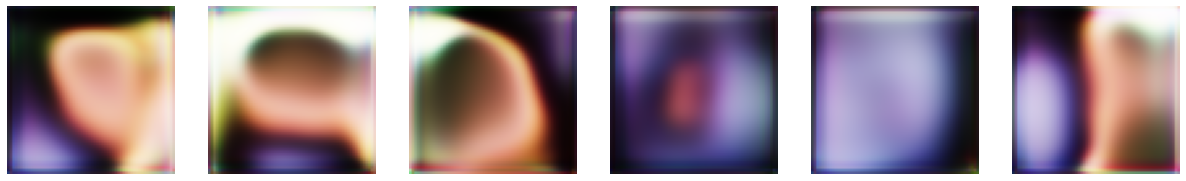

Step 368: g_loss 0.2905 critic_loss -2.9270 critic_fake -0.5848 critic_real -2.3421 penalty 0.0835


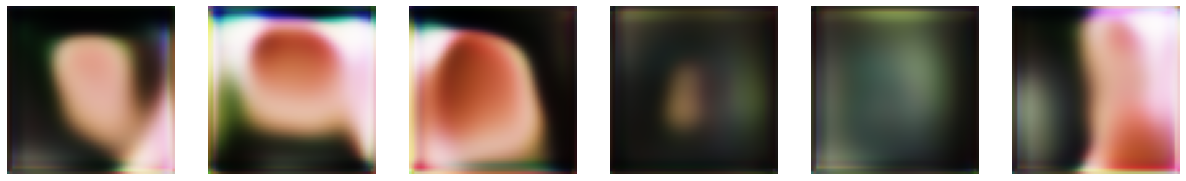

Step 384: g_loss 0.5554 critic_loss -2.8829 critic_fake -0.3880 critic_real -2.4949 penalty 0.2452


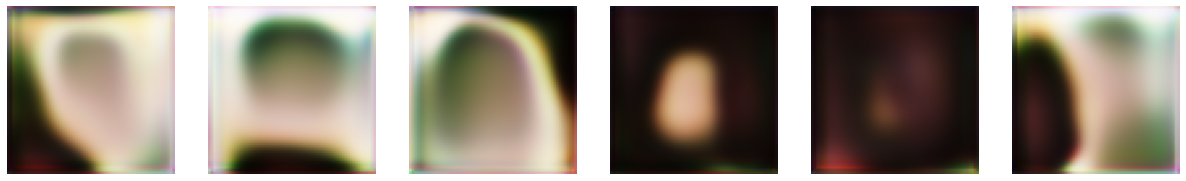

Step 400: g_loss 0.9111 critic_loss -2.3619 critic_fake -1.0151 critic_real -1.3468 penalty 0.0220


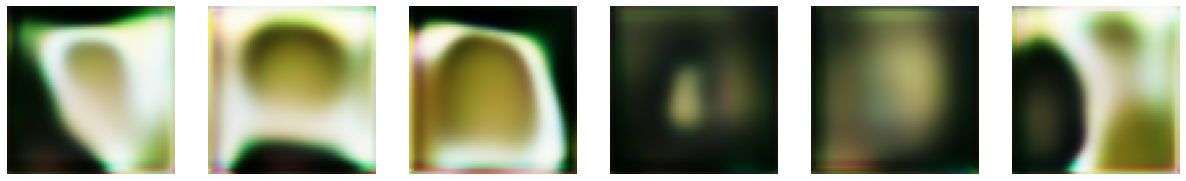

Step 416: g_loss 2.2020 critic_loss -2.4653 critic_fake -1.5439 critic_real -0.9214 penalty 0.0092


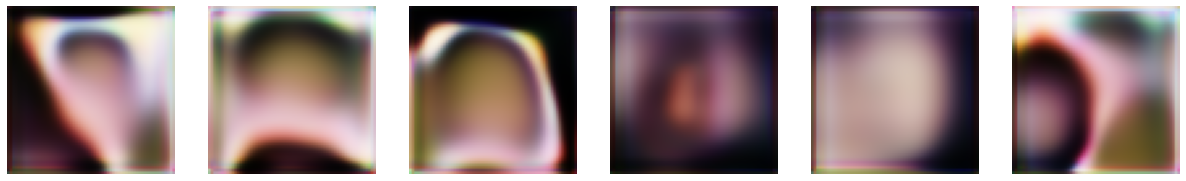

Step 432: g_loss 1.4377 critic_loss -2.6753 critic_fake -1.0554 critic_real -1.6199 penalty 0.1691


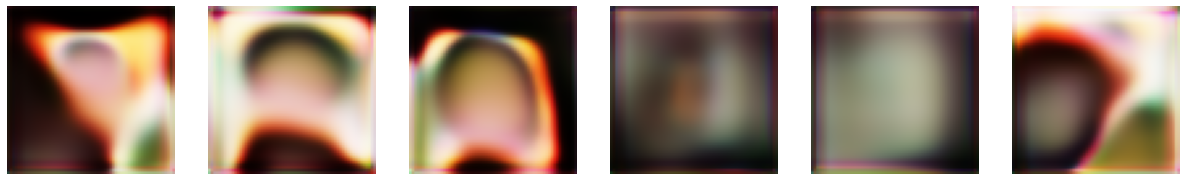

Step 448: g_loss 1.1914 critic_loss -3.2944 critic_fake -1.0502 critic_real -2.2442 penalty 0.7265


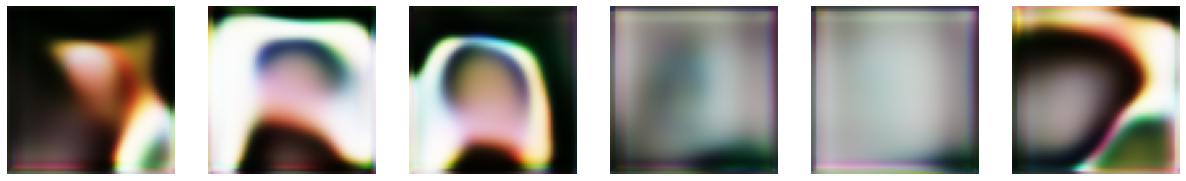

Step 464: g_loss 1.0431 critic_loss -2.4283 critic_fake -0.7515 critic_real -1.6767 penalty 0.2555


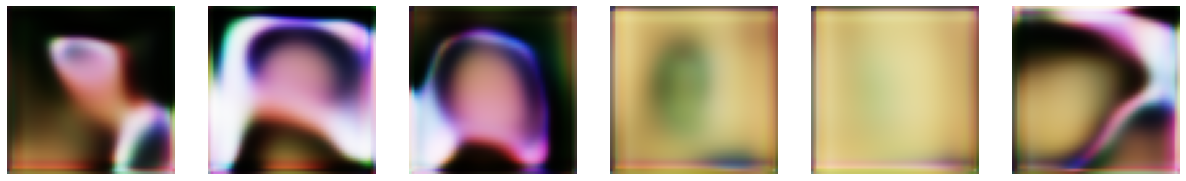

Step 480: g_loss -0.3258 critic_loss -2.4998 critic_fake -0.2351 critic_real -2.2647 penalty 0.0382


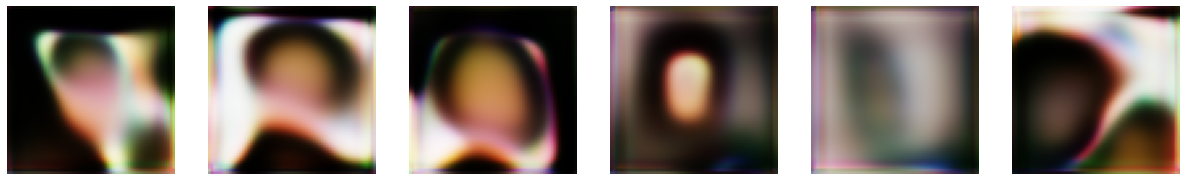

Step 496: g_loss 2.1074 critic_loss -2.2058 critic_fake -2.2191 critic_real 0.0132 penalty 0.0089


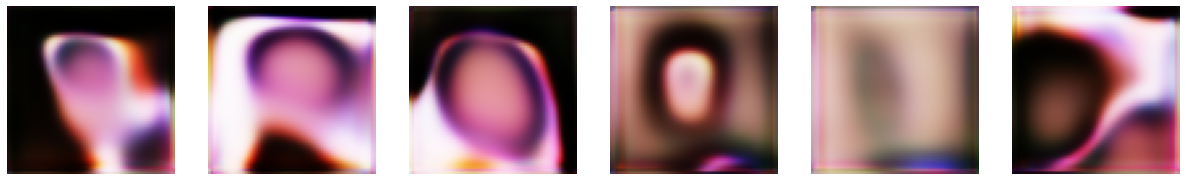

Step 512: g_loss 1.2558 critic_loss -2.3764 critic_fake -1.2308 critic_real -1.1457 penalty 0.2237


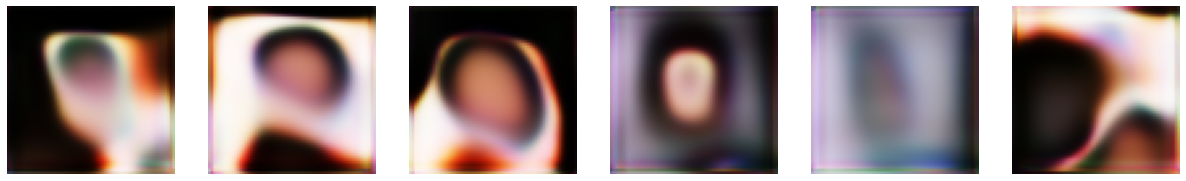

Step 528: g_loss 1.4711 critic_loss -2.3603 critic_fake -0.9529 critic_real -1.4074 penalty 0.1827


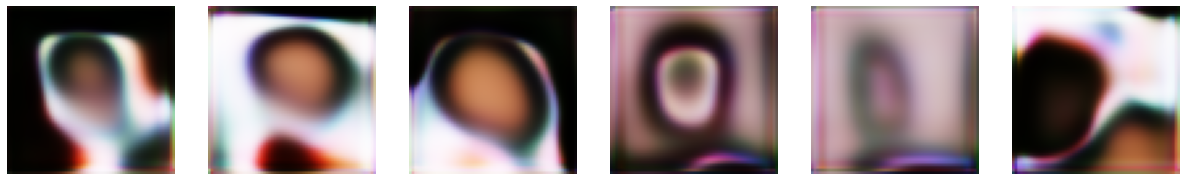

Step 544: g_loss -0.0907 critic_loss -2.0414 critic_fake -0.0119 critic_real -2.0295 penalty 0.0784


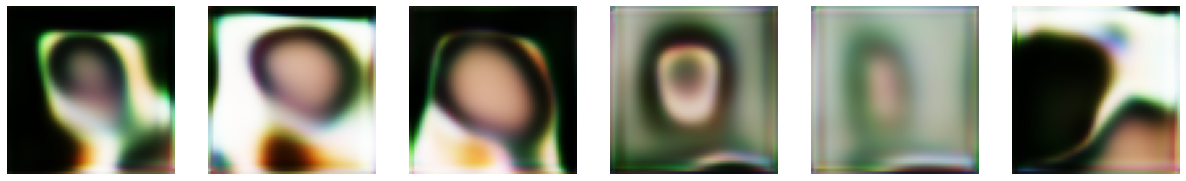

In [ ]:
wgan.train(iter(ds_train), batch_size, 50000, 16)

In [ ]:
wgan.model.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
wgan.generator.summary()

In [ ]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((6, 128))    
    images = wgan.generator.predict(z)
    grid_row = 1
    grid_col = 6
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off') 
    plt.show() 

In [ ]:
wgan.generator.save_weights('./wgan_gp_aflw2k3d.weights')